In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2
from collections import Counter
import pickle
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
#employee promotion
df=pd.read_csv('train_LZdllcl.csv', dtype={"previous_year_rating": "category"})
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3,2,0,0,73,0


In [3]:
#available columns in the dataframe
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [4]:
#data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   employee_id           54808 non-null  int64   
 1   department            54808 non-null  object  
 2   region                54808 non-null  object  
 3   education             52399 non-null  object  
 4   gender                54808 non-null  object  
 5   recruitment_channel   54808 non-null  object  
 6   no_of_trainings       54808 non-null  int64   
 7   age                   54808 non-null  int64   
 8   previous_year_rating  50684 non-null  category
 9   length_of_service     54808 non-null  int64   
 10  KPIs_met >80%         54808 non-null  int64   
 11  awards_won?           54808 non-null  int64   
 12  avg_training_score    54808 non-null  int64   
 13  is_promoted           54808 non-null  int64   
dtypes: category(1), int64(8), object(5)
memory usage: 5.5+

In [5]:
'''
converting categorical features by encoding
from the above categorical features in the given dataframe are :
(1). department
(2). region
(3). education
(4). gender
(5). recruitment_channel
(6). previous_year_rating
'''
print("the count of values in each categorical feature are")
print("The value counts in department are")
print(df['department'].value_counts())
print('\n')
print("The value counts in region feature are")
print(df['region'].value_counts())
print('\n')
print("The value counts in education feature are")
print(df['education'].value_counts())
print('\n')
print("The value counts in gender feature are")
print(df['gender'].value_counts())
print('\n')
print("The value counts in recruitment_channel feature are")
print(df['recruitment_channel'].value_counts())
print('\n')
print("The value counts in previous_year_rating feature are")
print(df['previous_year_rating'].value_counts())
print('\n')

the count of values in each categorical feature are
The value counts in department are
Sales & Marketing    16840
Operations           11348
Procurement           7138
Technology            7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64


The value counts in region feature are
region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34

In [6]:
#from the above we could see the missing values in education can be filled with mode of the columns
df['education'].fillna("""Master's & above""", inplace=True) #filling it with minority class to make the data balanced
df['previous_year_rating']=df['previous_year_rating'].fillna(method='ffill')

In [7]:
# Converting categorical variable into dummy/indicator variables.
df = pd.get_dummies(df)

In [8]:
df.shape

(54808, 64)

In [9]:
#employeeId plays no role in predicting promotion. so removing the column
df=df.drop(labels='employee_id',axis=1)

In [10]:
df.head()

,no_of_trainings,age,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Analytics,department_Finance,department_HR,...,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,previous_year_rating_1,previous_year_rating_2,previous_year_rating_3,previous_year_rating_4,previous_year_rating_5
0,1,35,8,1,0,49,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,1,30,4,0,0,60,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
2,1,34,7,0,0,50,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,2,39,10,0,0,50,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
4,1,45,2,0,0,73,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   no_of_trainings               54808 non-null  int64
 1   age                           54808 non-null  int64
 2   length_of_service             54808 non-null  int64
 3   KPIs_met >80%                 54808 non-null  int64
 4   awards_won?                   54808 non-null  int64
 5   avg_training_score            54808 non-null  int64
 6   is_promoted                   54808 non-null  int64
 7   department_Analytics          54808 non-null  uint8
 8   department_Finance            54808 non-null  uint8
 9   department_HR                 54808 non-null  uint8
 10  department_Legal              54808 non-null  uint8
 11  department_Operations         54808 non-null  uint8
 12  department_Procurement        54808 non-null  uint8
 13  department_R&D                5

In [12]:
#extracting target column from the dataframe
Y=df['is_promoted']
df=df.drop(labels='is_promoted',axis=1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=0.20, random_state=4)

In [14]:
normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

### Since this is a classification problem we will be using xgboost and adaboost classification models


In [15]:
#training and defining xgboost model

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(normalized_x_train, y_train)
y_train_pred = xgb_model.predict(normalized_x_train)
y_test_pred = xgb_model.predict(normalized_x_test)

print('the confusion matrix on training data is as follows')
print(confusion_matrix(y_train_pred, y_train))

print('the accuracy on test data is as follows')
print(accuracy_score(y_train_pred, y_train))

print('the confusion matrix on training data is as follows')
print(confusion_matrix(y_test_pred, y_test))

print('the accuracy on test data is as follows')
print(accuracy_score(y_test_pred, y_test))


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the confusion matrix on training data is as follows
[[40040  2220]
 [   41  1545]]
the accuracy on test data is as follows
0.948433152397026
the confusion matrix on training data is as follows
[[10015   585]
 [   44   318]]
the accuracy on test data is as follows
0.9426199598613392


In [17]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

xgb_model.fit(normalized_x_train, y_train, early_stopping_rounds=5, eval_set=[(normalized_x_test, y_test)])

y_pred = xgb_model.predict(normalized_x_test)

accuracy_score(y_test, y_pred)

[0]	validation_0-auc:0.84096
[1]	validation_0-auc:0.86146
[2]	validation_0-auc:0.86443
[3]	validation_0-auc:0.88617
[4]	validation_0-auc:0.89173
[5]	validation_0-auc:0.89584
[6]	validation_0-auc:0.90019
[7]	validation_0-auc:0.90483
[8]	validation_0-auc:0.90591
[9]	validation_0-auc:0.90571
[10]	validation_0-auc:0.90602
[11]	validation_0-auc:0.90590
[12]	validation_0-auc:0.90674
[13]	validation_0-auc:0.90673
[14]	validation_0-auc:0.90688
[15]	validation_0-auc:0.90644
[16]	validation_0-auc:0.90696
[17]	validation_0-auc:0.90764
[18]	validation_0-auc:0.90793
[19]	validation_0-auc:0.90760
[20]	validation_0-auc:0.90805
[21]	validation_0-auc:0.90835
[22]	validation_0-auc:0.90909
[23]	validation_0-auc:0.90916
[24]	validation_0-auc:0.90877
[25]	validation_0-auc:0.90879
[26]	validation_0-auc:0.90913
[27]	validation_0-auc:0.90895
[28]	validation_0-auc:0.90876


0.9443532202152892

In [18]:
from sklearn.ensemble import AdaBoostClassifier
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)

# Train Adaboost Classifer
model1 = abc.fit(normalized_x_train, y_train)

#Predict the response for test dataset
y_train_pred = model1.predict(normalized_x_train)
y_test_pred = model1.predict(normalized_x_test)


print('the confusion matrix on training data is as follows')
print(confusion_matrix(y_train_pred, y_train))

print('the accuracy on training data is as follows')
print(accuracy_score(y_train_pred, y_train))
print('\n')
print('the confusion matrix on test data is as follows')
print(confusion_matrix(y_test_pred, y_test))

print('the accuracy on test data is as follows')
print(accuracy_score(y_test_pred, y_test))

the confusion matrix on training data is as follows
[[39848  3097]
 [  233   668]]
the accuracy on training data is as follows
0.9240523650960178


the confusion matrix on test data is as follows
[[10002   740]
 [   57   163]]
the accuracy on test data is as follows
0.9272942893632549


In [19]:

cnf_matrix = confusion_matrix(y_test_pred,y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[10002   740]
 [   57   163]]


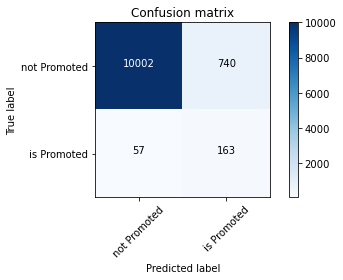

In [20]:
cnf_matrix = confusion_matrix(y_test_pred,y_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['not Promoted','is Promoted'], normalize=False,
                      title='Confusion matrix')